In [122]:
import numpy as np
import matplotlib.pyplot as plt

In [123]:
def f(x):
    if (x < -1):
        return x**2
    if (x < 0):
        return 1 + x**2
    if (x < 1):
        return x**2
    return 1 + x**2

In [124]:
def f_arr(x):
    fx = np.zeros(len(x))
    for i in range(len(x)):
        x_i = x[i]
        fx[i] = f(x_i)
    return fx

In [125]:
x = np.linspace(-2,2,101)
x_fine = np.linspace(-2,2,10001)
fx = f_arr(x)
dx = x[1] - x[0]

Text(0.5, 1.0, 'Problem Function')

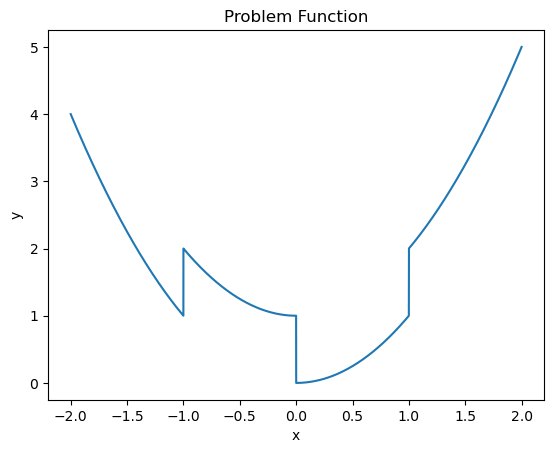

In [126]:
plt.plot(x_fine,f_arr(x_fine))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Problem Function")

## ENO

First, we wish to find $u_{i+\frac{1}{2}}$. We have a uniform mesh and a domain partitioned into computational cells $I_i = \left(x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}\right)$.

We require that $x_{i+\frac{1}{2}}$ and $x_{i-\frac{1}{2}}$ are included in the stencil.

So we take the initial stencil

$$
    \tilde{S} = \left\{I_{i}\right\} = \left\{x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}\right\}
$$

Then we extend to the left and right to create two candidate stencils, both of which contain this initial stencil:

$$
    \tilde{S}^{L}_{3} = \left\{I_{i-1}, I_{i}\right\} = \left\{x_{i-\frac{3}{2}}, x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}\right\}, \\
    \tilde{S}^{R}_{3} = \left\{I_{i}, I_{i+1}\right\} = \left\{x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}, x_{i+\frac{3}{2}}\right\}.
$$

Now, we are going to interpolate these values using the points we know on their corresponding stencils

$$
    S^{L}_{3} = \left\{x_{i-1}, x_{i} \right\}, \\
    S^{R}_{3} = \left\{x_{i}, x_{i+1} \right\}.
$$

The polynomials to interpolate these are

$$
    p^{L}_{3} = \frac{x - x_{i}}{x_{i-1} - x_{i}}u_{i-1} + \frac{x - x_{i-1}}{x_{i} - x_{i-1}}u_{i}, \\
    p^{R}_{3} = \frac{x - x_{i+1}}{x_{i} - x_{i+1}}u_{i} + \frac{x - x_{i}}{x_{i+1} - x_{i}}u_{i+1}.
$$

We therefore get the following approximations:

$$
    U^{L}\left(x_{i-\frac{3}{2}}\right) = p^{L}_{3}\left(x_{i-\frac{3}{2}}\right), U^{L}\left(x_{i-\frac{1}{2}}\right) = p^{L}_{3}\left(x_{i-\frac{1}{2}}\right), U^{L}\left(x_{i+\frac{1}{2}}\right) = p^{L}_{3}\left(x_{i+\frac{1}{2}}\right), \\
    U^{R}\left(x_{i-\frac{1}{2}}\right) = p^{R}_{3}\left(x_{i-\frac{1}{2}}\right), U^{R}\left(x_{i+\frac{1}{2}}\right) = p^{R}_{3}\left(x_{i+\frac{1}{2}}\right), U^{R}\left(x_{i+\frac{3}{2}}\right) = p^{R}_{3}\left(x_{i+\frac{3}{2}}\right).
$$

We then take the absolute value of the divided differences as the basis for which one we choose. So, if

$$
    \left|U\left[x_{i-\frac{3}{2}}, x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}\right]\right| < \left|U\left[x_{i-\frac{1}{2}}, x_{i-\frac{1}{2}}, x_{i+\frac{3}{2}}\right]\right|
$$

Then we go with $\tilde{S}^{L}_{3}$, else we go with $\tilde{S}^{R}_{3}$.

Here the divided differences are acquired recursively as

$$
U\left[x_{i-\frac{1}{2}}\right] = U\left(x_{i-\frac{1}{2}}\right), \\
U\left[x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}\right] = \frac{U\left[x_{i+\frac{1}{2}}\right] - U\left[x_{i-\frac{1}{2}}\right]}{x_{i+\frac{1}{2}} - x_{i-\frac{1}{2}}}, \\
U\left[x_{i-\frac{1}{2}}, ..., x_{i+j+\frac{1}{2}}\right] = \frac{U\left[x_{i+\frac{1}{2}}, ..., x_{i+j+\frac{1}{2}}\right] - U\left[x_{i-\frac{1}{2}}, ..., x_{i+j-\frac{1}{2}}\right]}{x_{i+j+\frac{1}{2}} - x_{i-\frac{1}{2}}}.
$$

In [127]:
def divided_difference(U,x):
    if len(U) == 1:
        return U[0]
    if len(U) == 2:
        return (U[1] - U[0])/(x[1]-x[0])
    else:
        N = len(U)
        return (divided_difference(U[0:N-1],x[0:N-1]) - divided_difference(U[1:N],x[1:N]))/(x[N-1] - x[0])
        

In [128]:
UL = np.zeros(3)
UR = np.zeros(3)

N = len(UL)

x_mesh_half = x[0:len(x)-1] + dx/2
fx_mesh_half_ENO = np.zeros(len(x_mesh_half))
fx_mesh_half_L = np.zeros(len(x_mesh_half))
fx_mesh_half_R = np.zeros(len(x_mesh_half))

In [129]:
for i in range(2,len(x_mesh_half)-1):

    pL = lambda x_arg : (x_arg - x[i])/(x[i-1] - x[i])*fx[i-1] + (x_arg - x[i-1])/(x[i] - x[i-1])*fx[i]
    pR = lambda x_arg : (x_arg - x[i+1])/(x[i] - x[i+1])*fx[i] + (x_arg - x[i])/(x[i+1] - x[i])*fx[i+1]

    UL[0] = pL(x_mesh_half[i-2])
    UL[1] = pL(x_mesh_half[i-1])
    UL[2] = pL(x_mesh_half[i  ])

    UR[0] = pR(x_mesh_half[i-1])
    UR[1] = pR(x_mesh_half[i  ])
    UR[2] = pR(x_mesh_half[i+1])

    x_stencil_L = x_mesh_half[i-2:i+1]
    x_stencil_R = x_mesh_half[i-1:i+2]

    dd_L = divided_difference(UL,x_stencil_L)
    dd_R = divided_difference(UR,x_stencil_R)

    if np.abs(dd_L) < np.abs(dd_R):
        fx_mesh_half_ENO[i] = pL(x_mesh_half[i])
    else:
        fx_mesh_half_ENO[i] = pR(x_mesh_half[i])
    fx_mesh_half_L[i] = pL(x_mesh_half[i])
    fx_mesh_half_R[i] = pR(x_mesh_half[i])

Text(0, 0.5, 'y')

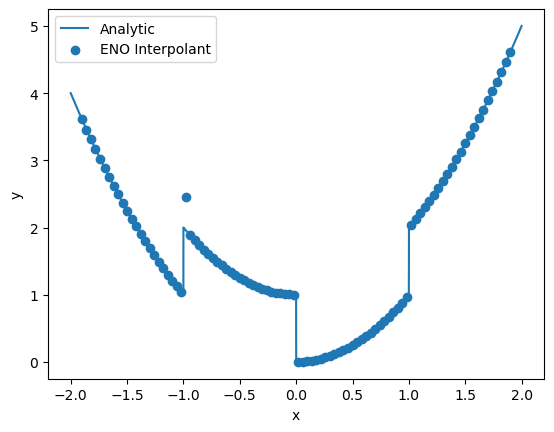

In [130]:
i_start = 2
i_end = -2
plt.plot(x_fine,f_arr(x_fine),label="Analytic")
plt.scatter(x_mesh_half[i_start:i_end],fx_mesh_half_ENO[i_start:i_end],label="ENO Interpolant")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'y')

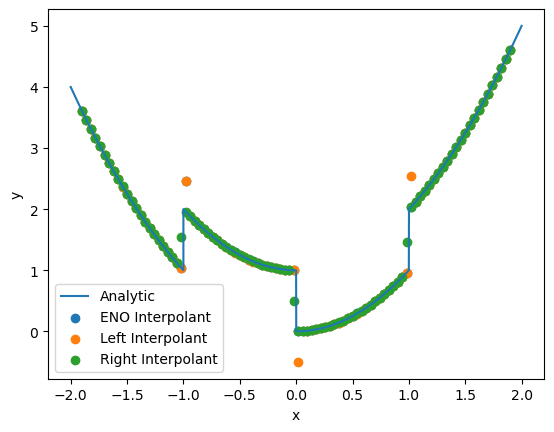

In [131]:
i_start = 2
i_end = -2
plt.plot(x_fine,f_arr(x_fine),label="Analytic")
plt.scatter(x_mesh_half[i_start:i_end],fx_mesh_half_ENO[i_start:i_end],label="ENO Interpolant")
plt.scatter(x_mesh_half[i_start:i_end],fx_mesh_half_L[i_start:i_end],label="Left Interpolant")
plt.scatter(x_mesh_half[i_start:i_end],fx_mesh_half_R[i_start:i_end],label="Right Interpolant")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

## Higher Order ENO

First, we wish to find $u_{i+\frac{1}{2}}$. We have a uniform mesh and a domain partitioned into computational cells $I_i = \left(x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}\right)$.

We require that $x_{i+\frac{1}{2}}$ and $x_{i-\frac{1}{2}}$ are included in the stencil.

So we take the initial stencil

$$
    \tilde{S} = \left\{I_{i}\right\} = \left\{x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}\right\}
$$

Then we extend to create three candidate stencils, all of which contain this initial stencil:

$$
    \tilde{S}^{(1)}_{3} = \left\{I_{i-2}, I_{i-1}, I_{i}\right\} = \left\{x_{i-\frac{5}{2}}, x_{i-\frac{3}{2}}, x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}\right\}, \\
    \tilde{S}^{(2)}_{3} = \left\{I_{i-1}, I_{i}, I_{i+1}\right\} = \left\{x_{i-\frac{3}{2}}, x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}, x_{i+\frac{3}{2}}\right\}, \\
    \tilde{S}^{(3)}_{3} = \left\{I_{i}, I_{i+1}, I_{i+2}\right\} = \left\{x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}, x_{i+\frac{3}{2}}, x_{i+\frac{5}{2}}\right\}.
$$

Now, we are going to interpolate these values using the points we know on their corresponding stencils

$$
    S^{(1)}_{3} = \left\{x_{i-2}, x_{i-1}, x_{i} \right\}, \\
    S^{(2)}_{3} = \left\{x_{i-1}, x_{i}, x_{i+1} \right\}, \\
    S^{(3)}_{3} = \left\{x_{i}, x_{i+1}, x_{i+2} \right\}.
$$

The polynomials to interpolate these are

$$
    p^{(1)}_{3} = \frac{\left(x - x_{i-1}\right)\left(x - x_{i}\right)}{\left(x_{i-2} - x_{i-1}\right)\left(x_{i-2} - x_{i}\right)}u_{i-2} + \frac{\left(x - x_{i-2}\right)\left(x - x_{i}\right)}{\left(x_{i-1} - x_{i-2}\right)\left(x_{i-1} - x_{i}\right)}u_{i-1} + \frac{\left(x - x_{i-2}\right)\left(x - x_{i-1}\right)}{\left(x_{i} - x_{i-2}\right)\left(x_{i} - x_{i-1}\right)}u_{i}, \\
    p^{(2)}_{3} = \frac{\left(x - x_{i}\right)\left(x - x_{i+1}\right)}{\left(x_{i-1} - x_{i}\right)\left(x_{i-1} - x_{i+1}\right)}u_{i-1} + \frac{\left(x - x_{i-1}\right)\left(x - x_{i+1}\right)}{\left(x_{i} - x_{i-1}\right)\left(x_{i} - x_{i+1}\right)}u_{i} + \frac{\left(x - x_{i-1}\right)\left(x - x_{i}\right)}{\left(x_{i+1} - x_{i-1}\right)\left(x_{i+1} - x_{i}\right)}u_{i+1}, \\
    p^{(3)}_{3} = \frac{\left(x - x_{i+1}\right)\left(x - x_{i+2}\right)}{\left(x_{i} - x_{i+1}\right)\left(x_{i} - x_{i+2}\right)}u_{i} + \frac{\left(x - x_{i}\right)\left(x - x_{i+2}\right)}{\left(x_{i+1} - x_{i}\right)\left(x_{i+1} - x_{i+2}\right)}u_{i+1} + \frac{\left(x - x_{i}\right)\left(x - x_{i+1}\right)}{\left(x_{i+2} - x_{i}\right)\left(x_{i+2} - x_{i+1}\right)}u_{i+2}.
$$

We therefore get the following approximations:

$$
    u^{(1)}\left(x_{i-\frac{5}{2}}\right) = p^{(1)}_{3}\left(x_{i-\frac{5}{2}}\right), u^{(1)}\left(x_{i-\frac{3}{2}}\right) = p^{(1)}_{3}\left(x_{i-\frac{3}{2}}\right), u^{(1)}\left(x_{i-\frac{1}{2}}\right) = p^{(1)}_{3}\left(x_{i-\frac{1}{2}}\right), u^{(1)}\left(x_{i+\frac{1}{2}}\right) = p^{(1)}_{3}\left(x_{i+\frac{1}{2}}\right), \\
    u^{(2)}\left(x_{i-\frac{3}{2}}\right) = p^{(2)}_{3}\left(x_{i-\frac{3}{2}}\right), u^{(2)}\left(x_{i-\frac{1}{2}}\right) = p^{(2)}_{3}\left(x_{i-\frac{1}{2}}\right), u^{(2)}\left(x_{i+\frac{1}{2}}\right) = p^{(2)}_{3}\left(x_{i-\frac{1}{2}}\right), u^{(2)}\left(x_{i+\frac{3}{2}}\right) = p^{(2)}_{3}\left(x_{i+\frac{3}{2}}\right), \\
    u^{(3)}\left(x_{i+\frac{1}{2}}\right) = p^{(3)}_{3}\left(x_{i+\frac{1}{2}}\right), u^{(3)}\left(x_{i+\frac{3}{2}}\right) = p^{(3)}_{3}\left(x_{i+\frac{3}{2}}\right), u^{(3)}\left(x_{i+\frac{3}{2}}\right) = p^{(3)}_{3}\left(x_{i+\frac{3}{2}}\right), u^{(3)}\left(x_{i+\frac{5}{2}}\right) = p^{(3)}_{3}\left(x_{i+\frac{5}{2}}\right).
$$

We then take the absolute value of the divided differences as the basis for which one we choose. ie we find

$$
    \min\left\{\left|u^{(1)}\left[x_{i-\frac{5}{2}},x_{i-\frac{3}{2}}, x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}\right]\right|, \left|u^{(2)}\left[x_{i-\frac{3}{2}}, x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}, x_{i+\frac{3}{2}}\right]\right|, \left|u^{(3)}\left[x_{i-\frac{1}{2}}, x_{i+\frac{1}{2}}, x_{i+\frac{3}{2}}, x_{i+\frac{5}{2}}\right]\right|\right\}.
$$

In [132]:
U1 = np.zeros(3)
U2 = np.zeros(3)
U3 = np.zeros(3)
U4 = np.zeros(3)

fx_mesh_half_1 = np.zeros(len(fx_mesh_half_ENO))
fx_mesh_half_2 = np.zeros(len(fx_mesh_half_ENO))
fx_mesh_half_3 = np.zeros(len(fx_mesh_half_ENO))
fx_mesh_half_4 = np.zeros(len(fx_mesh_half_ENO))

In [133]:
for i in range(2,len(x_mesh_half)-2):

    p1 = lambda x_arg : ((x_arg - x[i-1])*(x_arg - x[i]))/((x[i-2] - x[i-1])*(x[i-2] - x[i]))*fx[i-2] \
                      + ((x_arg - x[i-2])*(x_arg - x[i]))/((x[i-1] - x[i-2])*(x[i-1] - x[i]))*fx[i-1] \
                      + ((x_arg - x[i-2])*(x_arg - x[i-1]))/((x[i] - x[i-2])*(x[i] - x[i-1]))*fx[i  ]
    
    p2 = lambda x_arg : ((x_arg - x[i])*(x_arg - x[i+1]))/((x[i-1] - x[i])*(x[i-1] - x[i+1]))*fx[i-1] \
                      + ((x_arg - x[i-1])*(x_arg - x[i+1]))/((x[i] - x[i-1])*(x[i] - x[i+1]))*fx[i  ] \
                      + ((x_arg - x[i-1])*(x_arg - x[i]))/((x[i+1] - x[i-1])*(x[i+1] - x[i]))*fx[i+1]
    
    p3 = lambda x_arg : ((x_arg - x[i+1])*(x_arg - x[i+2]))/((x[i] - x[i+1])*(x[i] - x[i+2]))*fx[i  ] \
                      + ((x_arg - x[i])*(x_arg - x[i+2]))/((x[i+1] - x[i])*(x[i+1] - x[i+2]))*fx[i+1] \
                      + ((x_arg - x[i])*(x_arg - x[i+1]))/((x[i+2] - x[i])*(x[i+2] - x[i+1]))*fx[i+2]

    U1[0] = p1(x_mesh_half[i-2])
    U1[1] = p1(x_mesh_half[i-1])
    U1[2] = p1(x_mesh_half[i  ])

    U2[0] = p2(x_mesh_half[i-1])
    U2[1] = p2(x_mesh_half[i  ])
    U2[2] = p2(x_mesh_half[i+1])

    U3[0] = p3(x_mesh_half[i-1])
    U3[1] = p3(x_mesh_half[i  ])
    U3[2] = p3(x_mesh_half[i+1])

    x_stencil_1 = x_mesh_half[i-2:i+1]
    x_stencil_2 = x_mesh_half[i-1:i+2]
    x_stencil_3 = x_mesh_half[i  :i+3]

    dd_1 = divided_difference(U1,x_stencil_1)
    dd_2 = divided_difference(U2,x_stencil_2)
    dd_3 = divided_difference(U3,x_stencil_3)

    if np.abs(dd_1) < np.abs(dd_2):
        if np.abs(dd_1) < np.abs(dd_3):
            fx_mesh_half_ENO[i] = p1(x_mesh_half[i])
        else:
            fx_mesh_half_ENO[i] = p3(x_mesh_half[i])
    else:
        if np.abs(dd_2) < np.abs(dd_3):
            fx_mesh_half_ENO[i] = p2(x_mesh_half[i])
        else:
            fx_mesh_half_ENO[i] = p3(x_mesh_half[i])
    
    fx_mesh_half_1[i] = p1(x_mesh_half[i])
    fx_mesh_half_2[i] = p2(x_mesh_half[i])
    fx_mesh_half_3[i] = p3(x_mesh_half[i])

Text(0, 0.5, 'y')

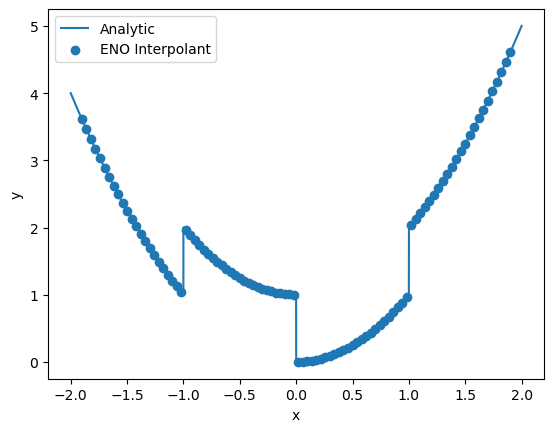

In [134]:
a = 2
b = -2

plt.plot(x_fine,f_arr(x_fine),label="Analytic")
plt.scatter(x_mesh_half[a:b],fx_mesh_half_ENO[a:b],label="ENO Interpolant")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

We see its superiority by simply comparing the vanilla Lagrange polynomial interpolation:

Text(0, 0.5, 'y')

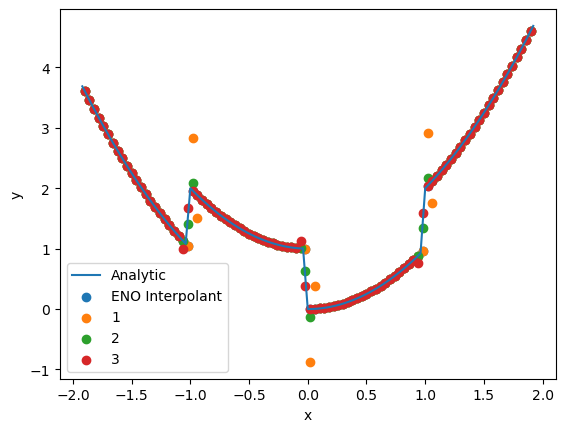

In [135]:
a = 2
b = -2
plt.plot(x[a:b],fx[a:b],label="Analytic")
plt.scatter(x_mesh_half[a:b],fx_mesh_half_ENO[a:b],label="ENO Interpolant")
plt.scatter(x_mesh_half[a:b],fx_mesh_half_1[a:b],label="1")
plt.scatter(x_mesh_half[a:b],fx_mesh_half_2[a:b],label="2")
plt.scatter(x_mesh_half[a:b],fx_mesh_half_3[a:b],label="3")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

# WENO

The above was ENO, basically taking several candidate stencils and choosing the best among them based on their divided differences. WENO suggests that we can do better by combining them.

Say we want an even larger polynomial interpolating $u_{i+\frac{1}{2}}$. If we interpolate five points, we see

$$
u_{i+\frac{1}{2}} = \frac{1}{30}u_{i-2} - \frac{13}{60}u_{i-1} + \frac{47}{60}u_{i} + \frac{9}{20}u_{i+1} - \frac{1}{20}u_{i+2}.
$$

Were we to combine this with the three point stencils that give us $u_{i+\frac{1}{2}}^{(1)}, u_{i+\frac{1}{2}}^{(2)}, u_{i+\frac{1}{2}}^{(3)}$, we would get the following

$$
u_{i+\frac{1}{2}} = \gamma_1u_{i+\frac{1}{2}}^{(1)} + \gamma_2u_{i+\frac{1}{2}}^{(2)} + \gamma_3u_{i+\frac{1}{2}}^{(3)}.
$$

We call the $\gamma_j$ constants the linear weights, which satisfy $\gamma_1 + \gamma_2 + \gamma_3 = 1$. In our case we have

$$
\gamma_1 = \frac{1}{10}, \gamma_2 = \frac{3}{5}, \gamma_3 = \frac{3}{10}.
$$

If the function is not smooth we use nonlinear weights to avoid the discontinuous cell in the stencil. 

$$
u_{i+\frac{1}{2}} = w_1u_{i+{1}{2}^{(1)}} + w_2u_{i+{1}{2}^{(2)}} + w_3u_{i+{1}{2}^{(3)}}.
$$

We call the $w_j$ constants the nonlinear weights, which satisfy $w_1 + w_2 + w_3 = 1$ and $w_j \geq 0 \forall j$. We determine these nonlinear weights by a "smoothness indicator" analagous to the divided difference measure for ENO. This smoothness indicator, $\beta_j$, can be computed a variety of ways but most often is computed using the method of Jiang and Shu (1996):

$$
\beta_j = \sum_{l=1}^{k}{\Delta x^{2l-1}\int_{x_{i-\frac{1}{2}}}^{x_{+\frac{1}{2}}} \left(\frac{d^l}{dx^l}p_j(x)\right)^2dx}.
$$

Here $k$ is the degree of the polynomial $j$. So for our purposes, $k=2$, and

$$
\begin{align}
&\beta_1 = \frac{13}{12}\left(u_{i-2} - 2u_{i-1} + u_{i}\right)^2 + \frac{1}{4}\left(u_{i-2} - 4u_{i-1} + 3u_{i}\right)^2, \\
&\beta_2 = \frac{13}{12}\left(u_{i-1} - 2u_{i} + u_{i+1}\right)^2 + \frac{1}{4}\left(u_{i-1} - u_{i+1}\right)^2, \\
&\beta_3 = \frac{13}{12}\left(u_{i} - 2u_{i+1} + u_{i+2}\right)^2 + \frac{1}{4}\left(3u_{i} - 4u_{i+1} + u_{i+2}\right)^2.
\end{align}
$$

We then define the nonlinear weights as

$$
w_j = \frac{\alpha_j}{\alpha_1 + \alpha_2 + \alpha_3}, \alpha_j = \frac{\gamma_j}{\left(\beta_j + \epsilon\right)^2}, \epsilon \approx 10^{-6}.
$$

In [136]:
fx_mesh_half_WENO = np.zeros(len(x_mesh_half))
gamma_1 = 1/10
gamma_2 = 3/5
gamma_3 = 3/10

eps = 10**-6

In [137]:
for i in range(2,len(x_mesh_half)-2):

    # ENO Section

    p1 = lambda x_arg : ((x_arg - x[i-1])*(x_arg - x[i]))/((x[i-2] - x[i-1])*(x[i-2] - x[i]))*fx[i-2] \
                      + ((x_arg - x[i-2])*(x_arg - x[i]))/((x[i-1] - x[i-2])*(x[i-1] - x[i]))*fx[i-1] \
                      + ((x_arg - x[i-2])*(x_arg - x[i-1]))/((x[i] - x[i-2])*(x[i] - x[i-1]))*fx[i  ]
    
    p2 = lambda x_arg : ((x_arg - x[i])*(x_arg - x[i+1]))/((x[i-1] - x[i])*(x[i-1] - x[i+1]))*fx[i-1] \
                      + ((x_arg - x[i-1])*(x_arg - x[i+1]))/((x[i] - x[i-1])*(x[i] - x[i+1]))*fx[i  ] \
                      + ((x_arg - x[i-1])*(x_arg - x[i]))/((x[i+1] - x[i-1])*(x[i+1] - x[i]))*fx[i+1]
    
    p3 = lambda x_arg : ((x_arg - x[i+1])*(x_arg - x[i+2]))/((x[i] - x[i+1])*(x[i] - x[i+2]))*fx[i  ] \
                      + ((x_arg - x[i])*(x_arg - x[i+2]))/((x[i+1] - x[i])*(x[i+1] - x[i+2]))*fx[i+1] \
                      + ((x_arg - x[i])*(x_arg - x[i+1]))/((x[i+2] - x[i])*(x[i+2] - x[i+1]))*fx[i+2]


    # Extending to WENO

    beta_1 = 13/12 * (fx[i-2] - 2*fx[i-1] + fx[i])**2 + 1/4 * (fx[i-2] - 4*fx[i-1] + 3*fx[i])**2
    beta_2 = 13/12 * (fx[i-1] - 2*fx[i] + fx[i+1])**2 + 1/4 * (fx[i-1] - fx[i+1])**2
    beta_3 = 13/12 * (fx[i] - 2*fx[i+1] + fx[i+2])**2 + 1/4 * (3*fx[i] - 4*fx[i+1] + fx[i+2])**2

    alpha_1 = gamma_1/((beta_1 + eps)**2)
    alpha_2 = gamma_1/((beta_2 + eps)**2)
    alpha_3 = gamma_1/((beta_3 + eps)**2)

    sum_alphas = alpha_1 + alpha_2 + alpha_3

    w_1 = alpha_1 / sum_alphas
    w_2 = alpha_2 / sum_alphas
    w_3 = alpha_3 / sum_alphas

    fx_mesh_half_WENO[i] = w_1 * p1(x_mesh_half[i]) + w_2*p2(x_mesh_half[i]) + w_3*p3(x_mesh_half[i])

Text(0, 0.5, 'y')

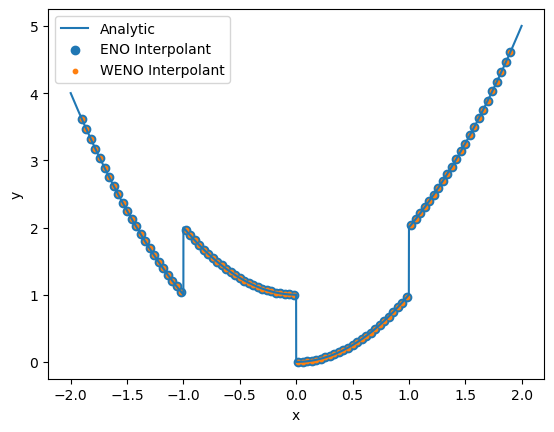

In [138]:
a = 2
b = -2

plt.plot(x_fine,f_arr(x_fine),label="Analytic")
plt.scatter(x_mesh_half[a:b],fx_mesh_half_ENO[a:b],label="ENO Interpolant")
plt.scatter(x_mesh_half[a:b],fx_mesh_half_WENO[a:b],label="WENO Interpolant", s=10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")